In [ ]:
# 그래프 한글
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae, mean_absolute_percentage_error as mape
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import make_scorer
import xgboost as xgb

# 한글
import matplotlib as mpl
import matplotlib.font_manager as fm
plt.rc('font', family='NanumBarunGothic')
mpl.rcParams['axes.unicode_minus'] = False

# 0.Load File

In [4]:
data = pd.read_pickle("sample_bundang.pkl")               # 태양광 발전량 train set
asos_wthr = pd.read_pickle("asos_info.pkl")               # 종관기상
prdt_wthr = pd.read_pickle("weather_prdt.pkl")            # 단기예보
solar_angle = pd.read_csv("solar_angle_2018_2022.csv", index_col='Unnamed: 0') # 방위각, 태양고도
test = pd.read_csv('test.csv') # 태양광 발전량 test set

print(
"태양광 발전량 :", data.shape, \
"\n종관기상 : ", asos_wthr.shape, \
"\n단기예보 : ", prdt_wthr.shape, \
"\n방위각, 태양고도 : ", solar_angle.shape,\
"\nTest : ", test.shape)

# column rename
data.rename(columns={'diff_day_gen2':'target'}, inplace=True)
asos_wthr.columns = ['location_cd', 'location_nm', 'ymdh', 'temp', 'rain', 'wind_speed', 'wind_dir', 'humid',
                     '증기압', 'dew_point', '현지기압', '일조', '일사', 'snow','cloud']

태양광 발전량 : (13224, 3) 
종관기상 :  (43819, 15) 
단기예보 :  (10728, 7) 
방위각, 태양고도 :  (1765, 10) 
Test :  (744, 3)


* train set : 태양광발전량 + 종관기상관측 + 태양고도/방위각 (2021.03~2022.09)
* test  set : 태양광발전량 + 단기예보    + 태양고도/방위각 (2022.10)

In [ ]:
display(data.head())
display(asos_wthr.head())
display(prdt_wthr.head())
display(solar_angle.head())
test.head()

In [5]:
# 평가지표 함수
def nmae_metric(answer, pred):
    capacity = 70 # capacity : 발전소 설비 용량
    absolute_error = abs(answer - pred) # 실제값과 정답값의 차이 절대값
    absolute_error /= capacity
    target_idx = answer[answer>=capacity*0.1].index
    nmae = 100 * absolute_error[target_idx].mean()
    return nmae

## 1. EDA

In [6]:
# solar_angle reshape(시간 컬럼)
# Split altitude, azimuth
# solar_angle columns : altitudeMeridian, altitude_09, altitude_12, altitude_15, altitude_18, azimuth_09, azimuth_12, azimuth_15, azimuth_18, date

# 태양고도/방위각 재구조화
def solar_angle_reshape(solar_angle):
    solar_angle_altitude = solar_angle[[col for col in solar_angle if 'altitude_' in col]+['date']]
    solar_angle_azimuth = solar_angle[[col for col in solar_angle if 'azimuth' in col]+['date']]

    # melt columns
    solar_altitude_melt = solar_angle_altitude.melt(id_vars='date',
                                                    value_vars=['altitude_09', 'altitude_12', 'altitude_15', 'altitude_18'],
                                                    var_name='hour',
                                                    value_name='altitude'
                                                 )

    solar_azimuth_melt = solar_angle_azimuth.melt(id_vars='date',
                                                value_vars=['azimuth_09', 'azimuth_12', 'azimuth_15', 'azimuth_18'],
                                                var_name='hour',
                                                value_name='azimuth'
                                             )

    # Make hour columns
    solar_altitude_melt['hour'] = solar_altitude_melt['hour'].apply(lambda x : int(x.replace('altitude_','')))
    solar_azimuth_melt['hour'] = solar_azimuth_melt['hour'].apply(lambda x : int(x.replace('azimuth_','')))

    # merge
    solar_angle_re = solar_altitude_melt.merge(solar_azimuth_melt, on =['date','hour'], how='inner')
    solar_angle_re = solar_angle_re.merge(solar_angle[['date','altitudeMeridian']], on ='date', how='left').sort_values('date').reset_index(drop=True)
    solar_angle_re.columns = ['ymd', 'hour', 'altitude', 'azimuth', 'altitudeMeridian']
    solar_angle_re['ymd'] = solar_angle_re['ymd'].astype('str')
    solar_angle_re['hour'] = solar_angle_re['hour'].astype('int')

    return solar_angle_re

# 날짜 정보 추출
def ext_time_info(df, ymd_col):
    df['ymd'] = pd.to_datetime(df['ymd'])
    df['year'] = df['ymd'].dt.year
    df['month'] = df['ymd'].dt.month
    df['day'] = df['ymd'].dt.day
    df['dayofweek'] = df['ymd'].dt.dayofweek
    df['dayofweek_ko'] = df['dayofweek'].apply(lambda x : '월화수목금토일'[x])
    df['ymd'] = df['ymd'].apply(lambda x : x.strftime('%Y%m%d'))
    return df

# 이슬점 계산식
def cal_dew_point(temperature, humidity):
    import math

    b = 17.62
    c = 243.12
    gamma = (b * temperature /(c + temperature)) + math.log(humidity / 100.0)
    dewpoint = (c * gamma) / (b - gamma)

    return dewpoint

In [7]:
train = ext_time_info(data, 'ymd') # 태양광 발전량 날짜 정보 추출(월,일)
solar_angle_re = solar_angle_reshape(solar_angle) # 태양고도/방위각 데이터 재구조화

# 종관기상정보 컬럼 정리
asos_wthr.columns = ['location_cd', 'location_nm', 'ymdh', 'temp', 'rain', 'wind_speed', 'wind_dir', 'humid',
                     '증기압', 'dew_point', '현지기압', '일조', '일사', 'snow','cloud']
asos_wthr['ymdh'] = pd.to_datetime(asos_wthr['ymdh'])
asos_wthr['ymd'] = asos_wthr['ymdh'].dt.date.apply(lambda x : x.strftime('%Y%m%d'))
asos_wthr['hour'] = asos_wthr['ymdh'].dt.hour

In [8]:
# 데이터 결합 ( energy + weather + solar angle )
print("Train set merge 전 : ", train.shape)
train = train.merge(asos_wthr, on=['ymd','hour'], how='left')
train = train.merge(solar_angle_re, on=['ymd','hour'], how='left')
train = train.sort_values(by=['ymd','hour'])
print("Train set merge 후 : ", train.shape)

Train set merge 전 :  (13224, 8)
Train set merge 후 :  (13224, 26)


In [9]:
# 테스트셋을 만들기 위해 단기예보 데이터 재구조화
prdt_wthr_filter = prdt_wthr[prdt_wthr['category'].str.contains('|'.join(['TMP','REH','WSD','VEC','SKY','PCP']))] # 기온, 습도, 풍속, 풍향, 전운, 강수
prdt_wthr_pivot = prdt_wthr_filter.pivot_table(index=['fcst_date','fcst_hour'], columns=['category'], values='values').reset_index()
prdt_wthr_pivot['fcst_hour'] = prdt_wthr_pivot['fcst_hour'].astype('int')

# test data set (solar energy + weather forecast + solar angle)
test['ymd'] = test['ymd'].astype('str')
test_prdt_wthr = test.merge(prdt_wthr_pivot, left_on=['ymd','hour'], right_on=['fcst_date','fcst_hour'], how='left').reset_index()
test_total = test_prdt_wthr.merge(solar_angle_re, on =['ymd','hour'], how='left')
print("Test set merge 전 : %s \nTset set merge 후 : %s"%(test.shape, test_total.shape))

Test set merge 전 : (744, 3) 
Tset set merge 후 : (744, 15)


In [10]:
# test set 컬럼 수정
test_total = ext_time_info(test_total, 'ymd')

# test_total['ymd'] = pd.to_datetime(test_total['ymd'])
# test_total['year'] = test_total['ymd'].dt.year
# test_total['month'] = test_total['ymd'].dt.month
# test_total['day'] = test_total['ymd'].dt.day
# test_total['dayofweek'] = test_total['ymd'].dt.dayofweek

# rename columns
test_total.rename(columns={'REH':'humid',
                            'SKY':'cloud',
                            'TMP':'temp',
                            'WSD':'wind_speed',
                            'VEC':'wind_dir',
                           'PCP':'rain'}, inplace=True)

In [ ]:
train.info()

In [ ]:
train.dtypes.value_counts()

In [ ]:
train.describe().T

In [ ]:
train.isnull().sum() / train.shape[0]

In [ ]:
train[train['location_cd'].isnull()]

* 강수량, 적설량 대부분 0으로 분석 제외
* 증기압, 현지기압, 일조, 일사 예측일에 사용하는 기상예보 정보에 없어 제외
* location_cd, location_nm 제외
* 전운량은 categorical feature
* wind_dir, altitude, azimuth, altitudeMeridian은 각도

In [ ]:
# temp = train.groupby('dayofweek', as_index=False)['target'].mean()
sns.boxplot(data = train, x='year', y='target')

In [ ]:
# 태양광 발전량 일 분포
plt.figure(figsize=(8,4))
plt.plot(range(len(train[train['ymd'].str.contains('202205')])), train[train['ymd'].str.contains('202205')]['target']);

In [82]:
# null 처리
train.isnull().sum()

ymd                     0
hour                    0
target                  0
year                    0
month                   0
day                     0
dayofweek               0
dayofweek_ko            0
location_cd             1
location_nm             1
ymdh                    1
temp                    1
rain                    0
wind_speed              2
wind_dir                2
humid                   1
증기압                     1
dew_point               1
현지기압                    1
일조                   5762
일사                   5766
snow                13118
cloud                   7
altitude                0
azimuth                 0
altitudeMeridian        0
dtype: int64

In [11]:
# 태양고도, 방위각 forward fill & backward fill
for n in ['altitude', 'azimuth', 'altitudeMeridian']:
    train[n].fillna(method='ffill', inplace=True)
    train[n].fillna(method='bfill', inplace=True)

    test_total[n].fillna(method='ffill', inplace=True)
    test_total[n].fillna(method='bfill', inplace=True)

In [12]:
# 강수량 null -> 0
# 나머지 선형 보간
# 사용하지 않는 컬럼 제외
drop_col = ['location_nm','location_cd','dayofweek_ko','현지기압','증기압', '일조','일사','snow','ymdh']
train['rain'].fillna(0, inplace=True)
train = train.drop(columns=drop_col).interpolate()

In [ ]:
# 일사, 일조


## 3. Feature Engineering

In [13]:
# cyclical feature
def encode(df, col, max_val):
    df[col + '_sin'] = np.sin(2 * np.pi * df[col]/max_val)
    df[col + '_cos'] = np.cos(2 * np.pi * df[col]/max_val)
    return df

# 테스트에 사용하는 단기예보 데이터가 (1, 3, 4) 범주형으로 제공
def cloud_categorical(df):
    df.loc[(df['cloud'] >= 0) &
            (df['cloud'] < 6), 'cloud_re'] =1
    df.loc[(df['cloud'] >= 6) &
            (df['cloud'] < 9), 'cloud_re'] =3
    df.loc[(df['cloud'] >= 9), 'cloud_re'] =4
    return df

def season_category(df):
    df.loc[(df['month']==1)|(df['month']==2)|(df['month']==12),'season'] = 4
    df.loc[(df['month'] >= 3)&(df['month']<6),'season'] = 1
    df.loc[(df['month'] >= 6)&(df['month']<9),'season'] = 2
    df.loc[(df['month'] >= 9)&(df['month']<12),'season'] = 3
    return df

In [14]:
# column to cyclical
for col, max_val in zip(['wind_dir','altitude','azimuth','altitudeMeridian','hour','month'],
                        [360,360,360,360,24,12]):
    train_enc = encode(train, col, max_val) # hour to cyclical
    test_enc = encode(test_total, col, max_val)

In [15]:
# 테스트에 사용하는 단기예보 데이터가 (1, 3, 4) 범주형으로 제공하여 종관기상정보 수정
train_enc = cloud_categorical(train_enc)
test_enc.rename(columns={'cloud':'cloud_re'}, inplace=True)

# season 추가
train_enc = season_category(train_enc)
test_enc = season_category(test_enc)

# test set - 이슬점 추가
test_enc['dew_point'] = np.nan
for n in range(test_enc.shape[0]):
    test_enc.loc[n,'dew_point'] = cal_dew_point(test_enc.loc[n,'temp'],test_enc.loc[n,'humid'])

In [ ]:
# 전일 날씨 또는 발전량 컬럼 추가
# moving average??

In [ ]:
sns.pairplot(train_enc);

In [ ]:
train_enc.corr()['target'].sort_values()

## 4. Modeling

In [16]:
# train, valid set 만들기
drop_col = ['ymd','month','hour','wind_dir','altitude', 'azimuth', 'altitudeMeridian', 'cloud','target']
train_x, val_x, train_y, val_y = train_test_split(train_enc.drop(columns=drop_col),
                                                  train_enc['target'],
                                                  test_size=0.1,
                                                  random_state=0)
test_x = test_enc[train_x.columns]
test_y = test_enc['target']

print("train : {}, valid : {}, test : {}".format(train_x.shape, val_x.shape, test_x.shape))

train : (11901, 22), valid : (1323, 22), test : (744, 22)


In [23]:
# XGBOOST
model_xgb = xgb.XGBRegressor(n_estimators=1000,
                             eval_metric = make_scorer(nmae_metric),
                             random_state=10
                             )
model_xgb.fit(train_x, train_y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=make_scorer(nmae_metric),
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, random_state=10, ...)

In [24]:
pred = model_xgb.predict(val_x)
print('valid set score : ', np.round(nmae_metric(val_y, pred),4))

valid set score :  5.944


#### 교차검증

In [19]:
# cross validation
kfold = KFold(n_splits=5, shuffle=True,random_state=0)
cv_accuracy = cross_val_score(model_xgb,
                               X=train_x,
                               y=train_y,
                               scoring=make_scorer(nmae_metric), #, greater_is_better=False
                               cv=kfold)

print('## 교차 검증 정확도:', cv_accuracy)
print('\n## 평균 검증 정확도:', round(np.mean(cv_accuracy), 4))

## 교차 검증 정확도: [6.72264258 6.3630195  6.08978501 6.94608069 6.14957619]

## 평균 검증 정확도: 6.4542


*

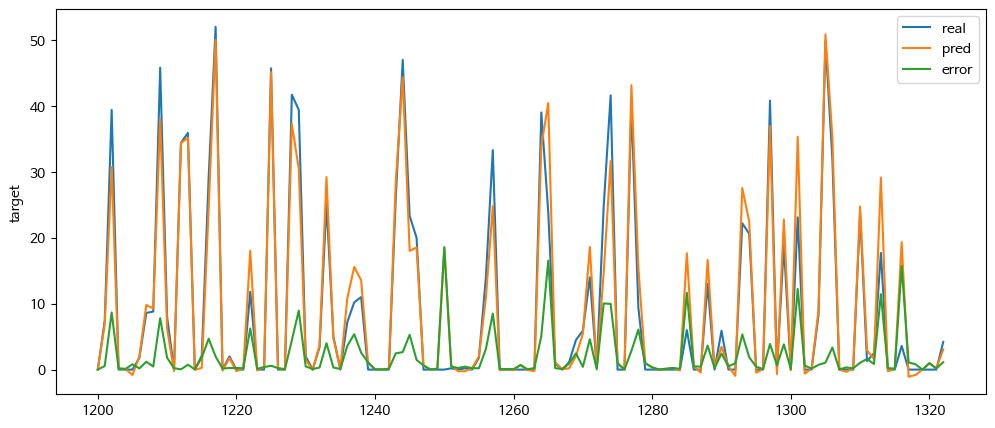

In [165]:
# 예측 결과 그래프
plt.figure(figsize=(12,5))
sns.lineplot(x=range(1200,len(val_y)),y=val_y[1200:], label='real')
sns.lineplot(x=range(1200,len(val_y)),y=pred[1200:], label='pred')
sns.lineplot(x=range(1200,len(val_y)),y=abs(val_y-pred)[1200:], label='error');

In [ ]:
# feature importance
pd.DataFrame({'feature':train_x.columns, 'importance':model_xgb.feature_importances_}).sort_values(by='importance', ascending=False)

#### Predict test

In [25]:
pred_test_xgb = model_xgb.predict(test_x)
print("test set score : ", np.round(nmae_metric(test_y, pred_test_xgb),4))

test set score :  8.0031


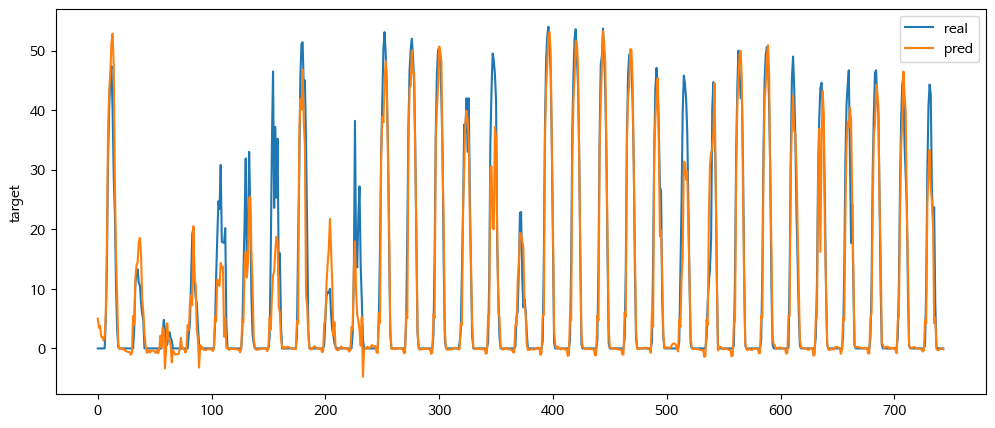

In [169]:
plt.figure(figsize=(12,5))
sns.lineplot(x=range(len(test_y)),y=test_y, label='real')
sns.lineplot(x=range(len(test_y)),y=pred_test_xgb, label='pred');
# sns.lineplot(x=range(len(test_y)),y=abs(test_y-pred), label='pred')

In [22]:
import lightgbm
model_lgbm = lightgbm.LGBMRegressor(n_estimators=100)

model_lgbm.fit(train_x, train_y)
pred_val_lgbm = model_lgbm.predict(val_x)
print("LightGBM Val set NMAE : ", nmae_metric(val_y, pred_val_lgbm))

pred_test_lgbm = model_lgbm.predict(test_x)
print("LightGBM Test set NMAE : ", nmae_metric(test_y, pred_test_lgbm))

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005728 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2414
[LightGBM] [Info] Number of data points in the train set: 11901, number of used features: 22
[LightGBM] [Info] Start training from score 9.943782
LightGBM Val set NMAE :  6.170447511359364
LightGBM Test set NMAE :  8.119504770665884


In [26]:
from sklearn.ensemble import RandomForestRegressor
model_rf = RandomForestRegressor(n_estimators=100, random_state=10)

model_rf.fit(train_x, train_y)
pred_val_rf = model_rf.predict(val_x)
print("RandomForest Val set NMAE : ", nmae_metric(val_y, pred_val_rf))

pred_test_rf = model_rf.predict(test_x)
print("RandomForest Test set NMAE : ", nmae_metric(test_y, pred_test_rf))

RandomForest Val set NMAE :  6.5561972331617815
RandomForest Test set NMAE :  7.008410803968257


In [27]:
from sklearn.ensemble import GradientBoostingRegressor
model_gb = GradientBoostingRegressor(n_estimators=100, random_state=10)

model_gb.fit(train_x, train_y)
pred_val_gb = model_gb.predict(val_x)
print("GB Val set NMAE : ", nmae_metric(val_y, pred_val_gb))

pred_test_gb = model_gb.predict(test_x)
print("GB Test set NMAE : ", nmae_metric(test_y, pred_test_gb))

GB Val set NMAE :  8.193540448080821
GB Test set NMAE :  8.840174929673726


In [ ]:
kfold = KFold(n_splits=5, shuffle=True,random_state=0)
cv_accuracy = cross_val_score(model_rf,
                               X=train_x,
                               y=train_y,
                               scoring=make_scorer(nmae_metric), #, greater_is_better=False
                               cv=kfold)

print('## 교차 검증 정확도:', cv_accuracy)
print('\n## 평균 검증 정확도:', round(np.mean(cv_accuracy), 4))

In [32]:
# Random Forest + XGB + LGBM
print("Random Forest + XGB + LGBM : ", nmae_metric(test_y, (pred_test_rf*0.3 + pred_test_xgb*0.3 + pred_test_lgbm*0.4)))

Random Forest + XGB + LGBM :  7.42265167092445


In [ ]:
plt.figure(figsize=(15,5))
# sns.lineplot(x=range(len(test_y)),y=test_y, label='real')
sns.lineplot(x=range(len(test_y)),y=abs(test_y - pred_test_xgb), label='xgb');
sns.lineplot(x=range(len(test_y)),y=abs(test_y - pred_test_rf), label='rf')
sns.lineplot(x=range(len(test_y)),y=abs(test_y - (pred_test_rf*0.3 + pred_test_xgb*0.3 + pred_test_lgbm*0.4)), label='ensemble');
# sns.lineplot(x=range(len(test_y)),y=abs(test_y-pred), label='pred')

In [ ]:
# optuna



#### 오차 원인 파악

In [ ]:
## n일 or n시간 전 기상 정보 컬럼 추가, 평균값, 분산값
## 전일 or n일 발전 평균값 컬럼 추가


In [ ]:
temp = asos_wthr[asos_wthr['ymd'].str.contains('202210')].reset_index(drop=True)
temp = cloud_categorical(temp)

plt.figure(figsize=(25,10))
for i, col in enumerate(['temp','rain','humid','wind_speed','dew_point','cloud_ct']):
    plt.subplot(3,2,i+1)
    sns.lineplot(data = test_x, x = test_x.index, y=col, label='real')
    sns.lineplot(data = temp, x= temp.index, y=col, label='pred');
    plt.title(col)
    plt.grid();

* 오차가 큰 기간(그래프 x축 100~200)에 전운량이 다른 기상정보에 비해 차이가 있어 보임

### 딥러닝 모델 테스트

In [98]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import  Dense, Dropout, Add, LSTM, Bidirectional, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.losses import MSE

In [37]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                     target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    pow = (end_index-history_size) // target_size
    for i in range(pow+1):
        data.append(dataset[i*target_size: (history_size+i*target_size) : step])
        labels.append(target[history_size+i*target_size: (history_size+(i+1)*target_size) : step])

    return np.array(data), np.array(labels)

In [38]:
# Data scaling
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

drop_col = ['ymd','month','hour','wind_dir','altitude', 'azimuth', 'altitudeMeridian', 'cloud','target']
scaling = StandardScaler()
scaling.fit(train_enc.drop(columns=drop_col))

x_train_scaled = pd.DataFrame(scaling.transform(train_enc.drop(columns=drop_col)), columns=train_enc.drop(columns=drop_col).columns)
x_test_scaled = pd.DataFrame(scaling.transform(test_enc[x_train_scaled.columns]), columns= x_train_scaled.columns)

In [40]:
past_history = 120  #24*5
future_target = 24  # 1일 24개 포인트
STEP = 1
x_train_lstm, y_train_lstm = multivariate_data(dataset = x_train_scaled,
                                               target = train_enc['target'],
                                               start_index = 0,
                                               end_index = x_train_scaled.shape[0] - 1680,
                                               history_size = past_history,
                                               target_size=future_target,
                                               step = STEP
                                              )

x_val_lstm, y_val_lstm = multivariate_data(dataset = x_train_scaled,
                                               target = train_enc['target'],
                                               start_index = x_train_scaled.shape[0] - 1680,
                                               end_index = None,
                                               history_size = past_history,
                                               target_size=future_target,
                                               step = STEP
                                              )
x_test_lstm, y_test_lstm = multivariate_data(dataset = x_test_scaled,
                                               target = test_enc['target'],
                                               start_index = x_test_scaled.shape[0],
                                               end_index = None,
                                               history_size = past_history,
                                               target_size=future_target,
                                               step = STEP
                                              )

### MLP

In [85]:
from tensorflow.keras import regularizers
tf.random.set_seed(2)

model_mlp = Sequential()
model_mlp.add(tf.keras.layers.Flatten(input_shape=x_train_lstm.shape[-2:]))
model_mlp.add(Dense(64, activation='relu',
                    kernel_initializer='he_normal',
                    kernel_regularizer=regularizers.L2(0.01),
                    activity_regularizer=regularizers.L2(1e-5)
                    ))
model_mlp.add(Dense(24))

model_mlp.compile(loss='MSE',
            optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.01),
            metrics = ['mae'])

model_mlp.summary()

history = model_mlp.fit(x_train_lstm, y_train_lstm,
                         epochs=30,
                         batch_size=20)

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_20 (Flatten)        (None, 2640)              0         
                                                                 
 dense_47 (Dense)            (None, 64)                169024    
                                                                 
 dense_48 (Dense)            (None, 24)                1560      
                                                                 
Total params: 170584 (666.34 KB)
Trainable params: 170584 (666.34 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/30
24/24 [==============================] - 1s 6ms/step - loss: 108.3515 - mae: 6.8762
Epoch 2/30
24/24 [==============================] - 0s 6ms/step - loss: 64.1377 - mae: 4.9410
Epoch 3/30
24/24 [==============================] - 0s 6ms/step - loss: 51.7553 - mae: 4

In [ ]:
plt.plot(history.history['loss']);

In [71]:
def nmae_metric_keras(answer, pred): # 대회 제공 평가지표 함수
    capacity = 70
    absolute_error = abs(answer - pred) # 실제값과 정답값의 차이 절대값
    absolute_error /= capacity # capacity : 발전소 발전용량
    target_arr = np.where(answer>=capacity*0.1, 1.0, 0.0)
    nmae = 100 * (absolute_error*target_arr).sum() / (target_arr).sum()
    return nmae

In [86]:
# valid set Score
pred = model_mlp.predict(x_val_lstm)
print("valid set score :", nmae_metric_keras(y_val_lstm, pred))

# test set score
pred_test = model_mlp.predict(x_test_lstm)
print("test set score : ", nmae_metric_keras(y_test_lstm, pred_test))

18/18 [==============================] - 0s 2ms/step
valid set score : 7.30223137890141
1/1 [==============================] - 0s 27ms/step
test set score :  11.619302265449829


In [ ]:
# 결과 그래프
plt.plot(y_test_lstm.flatten())
plt.plot(pred_test.flatten())

#### LSTM

In [114]:
model_lstm = Sequential()
model_lstm.add(GRU(64, input_shape=x_train_lstm.shape[-2:], kernel_initializer='he_normal')) #, return_sequences=True
# model_lstm.add(GRU(32,
#                     kernel_regularizer=regularizers.L2(0.01),
#                     activity_regularizer=regularizers.L2(1e-5)))
model_lstm.add(Dense(24))

model_lstm.compile(loss='mse',
            optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.01),
            metrics = ['mae'])

model_lstm.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_11 (GRU)                (None, 64)                16896     
                                                                 
 dense_56 (Dense)            (None, 24)                1560      
                                                                 
Total params: 18456 (72.09 KB)
Trainable params: 18456 (72.09 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [115]:
history = model_lstm.fit(x_train_lstm, y_train_lstm,
                          epochs=30,
                          batch_size=30)

Epoch 1/30
16/16 [==============================] - 24s 62ms/step - loss: 259.8730 - mae: 8.6499
Epoch 2/30
16/16 [==============================] - 2s 99ms/step - loss: 133.0959 - mae: 6.1049
Epoch 3/30
16/16 [==============================] - 2s 101ms/step - loss: 86.0114 - mae: 5.2582
Epoch 4/30
16/16 [==============================] - 1s 64ms/step - loss: 77.3370 - mae: 5.0794
Epoch 5/30
16/16 [==============================] - 1s 60ms/step - loss: 76.2154 - mae: 5.0197
Epoch 6/30
16/16 [==============================] - 1s 63ms/step - loss: 74.5687 - mae: 4.9962
Epoch 7/30
16/16 [==============================] - 1s 64ms/step - loss: 73.1551 - mae: 4.9250
Epoch 8/30
16/16 [==============================] - 1s 61ms/step - loss: 70.4362 - mae: 4.8555
Epoch 9/30
16/16 [==============================] - 1s 63ms/step - loss: 68.2921 - mae: 4.7430
Epoch 10/30
16/16 [==============================] - 1s 61ms/step - loss: 65.0480 - mae: 4.6329
Epoch 11/30
16/16 [==========================

In [112]:
pred = model_lstm.predict(x_val_lstm)
print("Val_set NMAE : ", nmae_metric_keras(y_val_lstm, pred))

pred_test = model_lstm.predict(x_test_lstm)
print("Test_set NMAE : ",nmae_metric_keras(y_test_lstm, pred_test))

18/18 [==============================] - 1s 14ms/step
Val_set NMAE :  10.438264316943126
1/1 [==============================] - 0s 38ms/step
Test_set NMAE :  11.210222933471563


In [ ]:
plt.plot(history.history['loss']);

In [ ]:
plt.plot(y_test_lstm.flatten())
plt.plot(pred_test.flatten());

### DLinear

In [117]:
class DLinear(keras.models.Model):
    """
    DLinear model as outlined in literature:
    https://arxiv.org/pdf/2205.13504.pdf

    Input and output data is expected in (batch, timesteps, features) format.
    """
    def __init__(self, output_shape, separate_features=False, kernel_size=25):
        super().__init__()
        self.kernel_size = kernel_size # The size of the kernel for the moving average
        self.output_steps = output_shape[0]
        self.output_features = output_shape[1]
        self.separate_features = separate_features
        self.kernel_initializer = "he_normal"


    def build(self, input_shape):
        """
        Build function to create necessary layers.
        """
        self.built_input_shape = input_shape

        if self.separate_features:
            self.trend_dense = []
            self.residual_dense = []
            for feature in range(self.output_features):
                self.trend_dense.append(keras.layers.Dense(self.output_steps,
                                                           kernel_initializer=self.kernel_initializer,
                                                          name="trend_decoder_feature_"+str(feature)))
                self.residual_dense.append(keras.layers.Dense(self.output_steps,
                                                               kernel_initializer=self.kernel_initializer,
                                                              name="residual_decoder_feature_"+str(feature)))
        else:
            self.trend_dense = keras.layers.Dense(self.output_steps*self.output_features,
                                                  kernel_initializer=self.kernel_initializer,
                                                 name="trend_recomposer")
            self.residual_dense = keras.layers.Dense(self.output_steps*self.output_features,
                                                     kernel_initializer=self.kernel_initializer,
                                                    name="residual_recomposer")

    def call(self, inputs):
        """
        I provide 2 settings to DLinear, as defined in literature.

        DLinear-S: separate_features = False
        Uses all input features to directly estimate output features, using 2 linear layers.

        DLinear-I: separate_features = True
        Uses all input features to directly estimate output features, using 2 linear layers
        PER OUTPUT CHANNEL.
        Theoretically better if scaling of output variables differ.
        """
        trend = keras.layers.AveragePooling1D(pool_size=self.kernel_size,
                                              strides=1,
                                              padding="same",
                                              name="trend_decomposer")(inputs)

        residual = keras.layers.Subtract(name="residual_decomposer")([inputs, trend])

        if self.separate_features:
            paths = []

            for feature in range(self.output_features):
                trend_sliced = keras.layers.Lambda(lambda x: x[:, :, feature],
                                                  name="trend_slicer_feature_"+str(feature))(trend)
                trend_sliced = self.trend_dense[feature](trend_sliced)
                trend_sliced = tf.keras.layers.Reshape((self.output_steps, 1),
                                                      name="reshape_trend_feature_"+str(feature))(trend_sliced)

                residual_sliced = keras.layers.Lambda(lambda x: x[:, :, feature],
                                                      name="residuals_slicer_feature_"+str(feature))(residual)
                residual_sliced = self.residual_dense[feature](residual_sliced)
                residual_sliced = tf.keras.layers.Reshape((self.output_steps, 1),
                                                          name="reshape_residual_feature_"+str(feature))(residual_sliced)

                path = keras.layers.Add(name="recomposer_feature_"+str(feature))([trend_sliced, residual_sliced])

                paths.append(path)

            reshape = keras.layers.Concatenate(axis=2,
                                              name="output_recomposer")(paths)
        else:
            flat_residual = keras.layers.Flatten()(residual)
            flat_trend = keras.layers.Flatten()(trend)

            residual = self.residual_dense(flat_residual)

            trend = self.trend_dense(flat_trend)

            add = keras.layers.Add(name="recomposer")([residual, trend])

            reshape = keras.layers.Reshape((self.output_steps, self.output_features))(add)

        return reshape

    def summary(self):
        """
        Override model.summary to allow usage on nested model.
        """
        if self.built:
            self.model().summary()
        else:
            # If we haven't built the model, show the normal error message.
            super().summary()

    def model(self):
        """
        Workaround to allow for methods on model to work.
        Model nesting gets janky in tensorflow, apparently.

        Use model.model() in place of model.

        e.g. tf.keras.utils.plot_model(model.model())
        """
        x = keras.layers.Input(shape=(self.built_input_shape[1:]))
        model = keras.models.Model(inputs=[x],outputs=self.call(x))

        return model

In [ ]:
import torch
class moving_avg(torch.nn.Module):
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = torch.nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x

class series_decomp(torch.nn.Module):
    def __init__(self, kernel_size):
        super(series_decomp, self).__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        residual = x - moving_mean
        return moving_mean, residual

 class LTSF_DLinear(torch.nn.Module):
    def __init__(self, window_size, forcast_size, kernel_size, individual, feature_size):
        super(LTSF_DLinear, self).__init__()
        self.window_size = window_size
        self.forcast_size = forcast_size
        self.decompsition = series_decomp(kernel_size)
        self.individual = individual
        self.channels = feature_size
        if self.individual:
            self.Linear_Seasonal = torch.nn.ModuleList()
            self.Linear_Trend = torch.nn.ModuleList()
            for i in range(self.channels):
                self.Linear_Trend.append(torch.nn.Linear(self.window_size, self.forcast_size))
                self.Linear_Trend[i].weight = torch.nn.Parameter((1/self.window_size)*torch.ones([self.forcast_size, self.window_size]))
                self.Linear_Seasonal.append(torch.nn.Linear(self.window_size, self.forcast_size))
                self.Linear_Seasonal[i].weight = torch.nn.Parameter((1/self.window_size)*torch.ones([self.forcast_size, self.window_size]))
        else:
            self.Linear_Trend = torch.nn.Linear(self.window_size, self.forcast_size)
            self.Linear_Trend.weight = torch.nn.Parameter((1/self.window_size)*torch.ones([self.forcast_size, self.window_size]))
            self.Linear_Seasonal = torch.nn.Linear(self.window_size,  self.forcast_size)
            self.Linear_Seasonal.weight = torch.nn.Parameter((1/self.window_size)*torch.ones([self.forcast_size, self.window_size]))

    def forward(self, x):
        trend_init, seasonal_init = self.decompsition(x)
        trend_init, seasonal_init = trend_init.permute(0,2,1), seasonal_init.permute(0,2,1)
        if self.individual:
            trend_output = torch.zeros([trend_init.size(0), trend_init.size(1), self.forcast_size], dtype=trend_init.dtype).to(trend_init.device)
            seasonal_output = torch.zeros([seasonal_init.size(0), seasonal_init.size(1), self.forcast_size], dtype=seasonal_init.dtype).to(seasonal_init.device)
            for idx in range(self.channels):
                trend_output[:, idx, :] = self.Linear_Trend[idx](trend_init[:, idx, :])
                seasonal_output[:, idx, :] = self.Linear_Seasonal[idx](seasonal_init[:, idx, :])
        else:
            trend_output = self.Linear_Trend(trend_init)
            seasonal_output = self.Linear_Seasonal(seasonal_init)
        x = seasonal_output + trend_output
        return x.permute(0,2,1)

In [1]:
def standardization(train_df, test_df, not_col, target):
    train_df_ = train_df.copy()
    test_df_ = test_df.copy()
    col =  [col for col in list(train_df.columns) if col not in [not_col]]
    mean_list = []
    std_list = []
    for x in col:
        mean, std = train_df_.agg(["mean", "std"]).loc[:,x]
        mean_list.append(mean)
        std_list.append(std)
        train_df_.loc[:, x] = (train_df_[x] - mean) / std
        test_df_.loc[:, x] = (test_df_[x] - mean) / std
    return train_df_, test_df_, mean_list[col.index(target)], std_list[col.index(target)]

def time_slide_df(df, window_size, forcast_size, date, target):
    df_ = df.copy()
    data_list = []
    dap_list = []
    date_list = []
    for idx in range(0, df_.shape[0]-window_size-forcast_size+1):
        x = df_.loc[idx:idx+window_size-1, target].values.reshape(window_size, 1)
        y = df_.loc[idx+window_size:idx+window_size+forcast_size-1, target].values
        date_ = df_.loc[idx+window_size:idx+window_size+forcast_size-1, date].values
        data_list.append(x)
        dap_list.append(y)
        date_list.append(date_)
    return np.array(data_list, dtype='float32'), np.array(dap_list, dtype='float32'), np.array(date_list)

class Data(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

### Univariable ###
### 데이터 셋 생성 ###
window_size = 72
forcast_size= 24
batch_size = 32
targets = '전력사용량(kWh)'
date = 'date_time'

train_df_fe, test_df_fe, mean_, std_ = standardization(train_df, test_df, 'date_time', targets)
train_x, train_y, train_date = time_slide_df(train_df_fe, window_size, forcast_size, date, targets)
test_x, test_y, test_date = time_slide_df(test_df_fe, window_size, forcast_size, date, targets)

train_ds = Data(train_x[:1000], train_y[:1000])
valid_ds = Data(train_x[1000:], train_y[1000:])
test_ds = Data(test_x, test_y)

train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle=True,)
valid_dl = DataLoader(valid_ds, batch_size = train_x[1000:].shape[0], shuffle=False)
test_dl  = DataLoader(test_ds,  batch_size = test_x.shape[0], shuffle=False)


### 모델 학습 ###
train_loss_list = []
valid_loss_list = []
test_loss_list = []
epoch = 50
lr = 0.001
DLinear_model = LTSF_DLinear(
                            window_size=window_size,
                            forcast_size=forcast_size,
                            kernel_size=25,
                            individual=False,
                            feature_size=1,
                            )
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(DLinear_model.parameters(), lr=lr)
max_loss = 999999999

for epoch in tqdm(range(1, epoch+1)):
    loss_list = []
    DLinear_model.train()
    for batch_idx, (data, target) in enumerate(train_dl):
        optimizer.zero_grad()
        output = DLinear_model(data)
        loss = criterion(output, target.unsqueeze(-1))
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
    train_loss_list.append(np.mean(loss_list))

    DLinear_model.eval()
    with torch.no_grad():
        for data, target in valid_dl:
            output = DLinear_model(data)
            valid_loss = criterion(output, target.unsqueeze(-1))
            valid_loss_list.append(valid_loss)

        for data, target in test_dl:
            output = DLinear_model(data)
            test_loss = criterion(output, target.unsqueeze(-1))
            test_loss_list.append(test_loss)

    if valid_loss < max_loss:
        torch.save(DLinear_model, 'DLinear_model.pth')
        max_loss = valid_loss
        print("valid_loss={:.3f}, test_los{:.3f}, Model Save".format(valid_loss, test_loss))
        dlinear_best_epoch = epoch
        dlinear_best_train_loss = np.mean(loss_list)
        dlinear_best_valid_loss = np.mean(valid_loss.item())
        dlinear_best_test_loss = np.mean(test_loss.item())

    print("epoch = {}, train_loss : {:.3f}, valid_loss : {:.3f}, test_loss : {:.3f}".format(epoch, np.mean(loss_list), valid_loss, test_loss))

In [289]:
x_train_lstm.shape

(479, 72, 22)

In [ ]:
# 예측 개선 작업
# 예측 차이 큰 날

test_result['pred'] = pred
test_result['error'] = abs(test_result['target']-test_result['pred'])
test_result[test_result['error'] > 10].head()